# Variational Quantum Eigensolver (VQE) - Modular Framework Demo

This notebook demonstrates the design of our VQE framework. The framework is built using a **mixin-based architecture** that allows you to combine different components:

- **Quantum Systems**: OneQubitSystem, IsingModel, HydrogenMolecule
- **Ansätze**: TrivialAnsatz, RealAmplitudesAnsatz, ComplexAnsatz
- **Gradient Methods**: FiniteDifferenceGradient, ParameterShiftGradient, SPSAGradient
- **Optimizers**: GradientDescent, QuantumNaturalGradient, Adam
- **Step Size Strategies**: ConstantStepSize, DecayingStepSize

---

## Setup and Imports

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys

# Add source directory to path
sys.path.append("src")

# Import the VQE framework
from VQE_applications import *

# Setup results directory
RESULTS_DIR = Path("results/demo")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# Set random seed for reproducibility
np.random.seed(42)

## The Modular Design

### How to Build a Custom VQE

The framework uses **multiple inheritance** to compose VQE algorithms from modular components:

```python
class MyCustomVQE(
    GradientMethod,        # How to compute gradients
    OptimizerType,         # Which classical update routine to use
    StepSizeStrategy,      # Which learning rate to use
    AnsatzType,            # Circuit structure for state parameterization
    QuantumSystem          # Hamiltonian to minimize
):
    pass
```

### Example: Building a Simple VQE

Let's construct a VQE optimizer step by step:

In [10]:
# Define a custom VQE by combining components
class OneQubitVQE(
    ParameterShiftGradient,    # Exact quantum gradient
    GradientDescent,           # Standard gradient descent
    ConstantStepSize,          # Fixed learning rate
    TrivialAnsatz,             # Simple Ry rotations
    OneQubitSystem             # Single qubit H = -X - Z
):
    """Custom VQE with parameter shift rule and constant learning rate"""
    pass

# Instantiate and run
vqe = OneQubitVQE(
    max_iter=50,
    learning_rate=0.1,
    store_history=True
)

# Initialize parameters and optimize
theta_init = np.array([np.pi/4])  # Start at 45°
theta_opt, E_opt = vqe.run(theta_init)

print(f"\nOptimal parameters: {theta_opt}")
print(f"Ground state energy: {E_opt:.6f}")
print(f"Exact ground state: {-np.sqrt(2):.6f}")
print(f"Error: {abs(E_opt - (-np.sqrt(2))):.2e}")

Iteration 0/50 (0.0%)
Converged at iteration 0

Optimal parameters: [0.78539816]
Ground state energy: -1.414214
Exact ground state: -1.414214
Error: 2.22e-16


---
## Part 1: Single Qubit System

We start with the simplest case: a single qubit with Hamiltonian:

$$H = -X - Z = -\begin{pmatrix} 1 & 1 \\ 1 & -1 \end{pmatrix}$$

**Exact ground state energy**: $E_0 = -\sqrt{2} \approx -1.414$

### Comparing Different Optimizers

In [11]:
configs = [
    {
        'name': 'Finite Difference + Constant Step',
        'class': VQE_OneQubit_FiniteDiff_Const_Real,
        'params': {'max_iter': 100, 'learning_rate': 0.1, 'reps': 1, 'store_history': True}
    },
    {
        'name': 'Parameter Shift + Adam',
        'class': VQE_OneQubit_PSR_Adam,
        'params': {'max_iter': 100, 'learning_rate': 0.1, 'reps': 1, 'store_history': True}
    },
    {
        'name': 'Quantum Natural Gradient',
        'class': VQE_OneQubit_QNG,
        'params': {'max_iter': 100, 'learning_rate': 0.1, 'decay': 0.01, 'reps': 1, 'store_history': True}
    }
]

results = {}
exact_energy = -np.sqrt(2)

n_params = 2  
theta_init = np.random.uniform(0, 2*np.pi, n_params)

for config in configs:
    vqe = config['class'](**config['params'])
    theta_opt, E_opt = vqe.run(theta_init.copy())
    
    results[config['name']] = {
        'energy': E_opt,
        'error': abs(E_opt - exact_energy),
        'history': vqe.history_energy
    }
    
    print(f"  Final Energy: {E_opt:.6f}")
    print(f"  Error: {abs(E_opt - exact_energy):.2e}")

Iteration 0/100 (0.0%)
Iteration 10/100 (10.0%)
Iteration 20/100 (20.0%)
Converged at iteration 21
  Final Energy: -1.414213
  Error: 7.85e-07
Iteration 0/100 (0.0%)
Iteration 10/100 (10.0%)
Iteration 20/100 (20.0%)
Iteration 30/100 (30.0%)
Iteration 40/100 (40.0%)
Iteration 50/100 (50.0%)
Iteration 60/100 (60.0%)
Iteration 70/100 (70.0%)
Iteration 80/100 (80.0%)
Converged at iteration 85
  Final Energy: -1.414125
  Error: 8.85e-05
Iteration 0/100 (0.0%)
Iteration 10/100 (10.0%)
Converged at iteration 10
  Final Energy: -1.414213
  Error: 9.88e-08


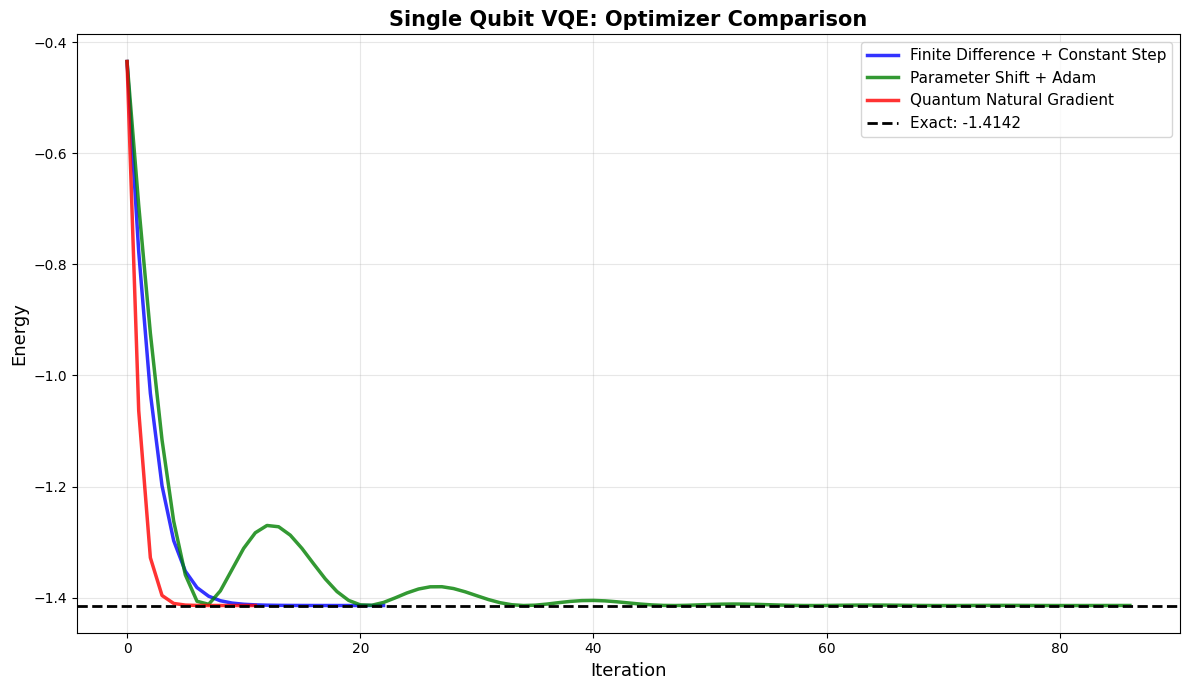


 Saved: results/demo/single_qubit_comparison.png


In [12]:
# Plot convergence comparison
fig, ax = plt.subplots(1, 1, figsize=(12, 7))

colors = ['blue', 'green', 'red']
for i, (name, data) in enumerate(results.items()):
    ax.plot(data['history'], linewidth=2.5, label=name, color=colors[i], alpha=0.8)

ax.axhline(y=exact_energy, color='black', linestyle='--', linewidth=2, 
           label=f'Exact: {exact_energy:.4f}')

ax.set_xlabel('Iteration', fontsize=13)
ax.set_ylabel('Energy', fontsize=13)
ax.set_title('Single Qubit VQE: Optimizer Comparison', fontsize=15, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11, loc='best')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'single_qubit_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n Saved: {RESULTS_DIR / 'single_qubit_comparison.png'}")

---
## Part 2: Ising Model

The Ising model describes interacting spins with Hamiltonian:

$$H = -\sum_i h_i Z_i - \sum_{i<j} J_{ij} Z_i Z_j$$

We'll study a **3-qubit Ising chain** with:
- External field: $h_i = 0.5$ for all spins
- Coupling Matrix: $J_{i,j}$

### Comparing Gradient Methods

In [56]:
J = np.array([
    [0.0,  1.0,  0.5],
    [1.0,  0.0,  0.8],
    [0.5,  0.8,  0.0],
], dtype=float)

n_qubits = J.shape[0]

# reps used in your Ising ansatz
opti_reps = 0
n_params = (opti_reps + 1) * n_qubits

h = 0.5 * np.ones(n_qubits)

print(f"\nSystem: {n_qubits}-qubit Ising chain")
print(f"Coupling J = {J[0,1]}")
print(f"External field h = {h[0]}")


System: 3-qubit Ising chain
Coupling J = 1.0
External field h = 0.5


In [57]:
# Build optimizer instances with specified configurations
optimizers_ising = {
    'Finite Diff.': VQE_Ising_QNG_finit(
        max_iter=200,
        learning_rate=0.01,
        store_history=True,
        reps=opti_reps,
        J=J,
        h=h
    ),
    'SPSA': VQE_Ising_QNG_spsa(
        max_iter=200,
        learning_rate=0.01,
        gradient_eps=0.1,
        store_history=True,
        reps=opti_reps,
        J=J,
        h=h
    ),
    'PSR': VQE_Ising_QNG_psr(
        max_iter=200,
        learning_rate=0.01,
        decay=0.02,
        store_history=True,
        reps=opti_reps,
        J=J,
        h=h
    )
}

# Initialize with small random values
theta_init = np.random.uniform(0, 0.5, n_params)

ising_results = {}

for name, vqe in optimizers_ising.items():
    print(f"{name}:")
    print("-" * 40)
    
    theta_opt, E_opt = vqe.run(theta_init)
    
    ising_results[name] = {
        'energy': E_opt,
        'history': vqe.history_energy,
        'params': theta_opt
    }
    
    print(f"  Final Energy: {E_opt:.6f}\n")

# Find best result
best_energy = min([res['energy'] for res in ising_results.values()])
print(f"Best ground state estimate: {best_energy:.6f}")

Finite Diff.:
----------------------------------------
Iteration 0/200 (0.0%)
Iteration 10/200 (5.0%)
Iteration 20/200 (10.0%)
Iteration 30/200 (15.0%)
Iteration 40/200 (20.0%)
Iteration 50/200 (25.0%)
Iteration 60/200 (30.0%)
Iteration 70/200 (35.0%)
Iteration 80/200 (40.0%)
Converged at iteration 87
  Final Energy: -3.799989

SPSA:
----------------------------------------
Iteration 0/200 (0.0%)
Iteration 10/200 (5.0%)
Iteration 20/200 (10.0%)
Iteration 30/200 (15.0%)
Converged at iteration 33
  Final Energy: -3.798091

PSR:
----------------------------------------
Iteration 0/200 (0.0%)
Iteration 10/200 (5.0%)
Iteration 20/200 (10.0%)
Iteration 30/200 (15.0%)
Iteration 40/200 (20.0%)
Iteration 50/200 (25.0%)
Iteration 60/200 (30.0%)
Iteration 70/200 (35.0%)
Iteration 80/200 (40.0%)
Iteration 90/200 (45.0%)
Iteration 100/200 (50.0%)
Iteration 110/200 (55.0%)
Converged at iteration 113
  Final Energy: -3.799979

Best ground state estimate: -3.799989


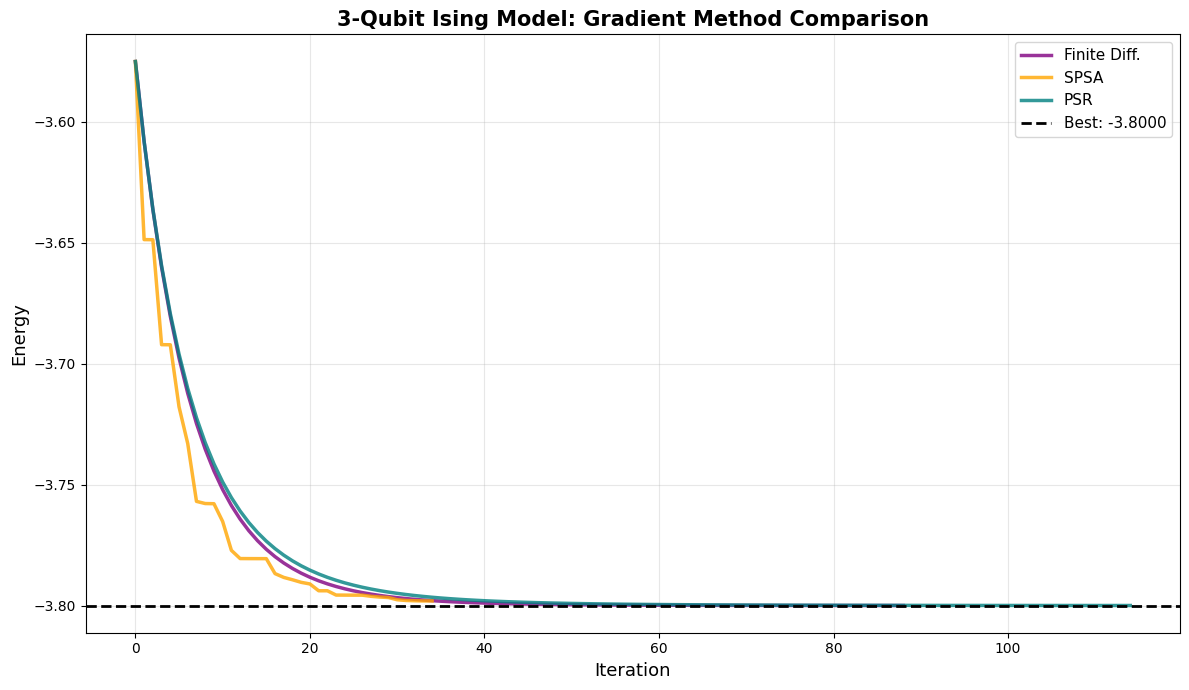


 Saved: results/demo/ising_gradient_comparison.png


In [58]:
# Plot Ising model convergence
fig, ax = plt.subplots(1, 1, figsize=(12, 7))

colors = ['purple', 'orange', 'teal']
for i, (name, data) in enumerate(ising_results.items()):
    ax.plot(data['history'], linewidth=2.5, label=name, color=colors[i], alpha=0.8)

ax.axhline(y=best_energy, color='black', linestyle='--', linewidth=2, 
           label=f'Best: {best_energy:.4f}')

ax.set_xlabel('Iteration', fontsize=13)
ax.set_ylabel('Energy', fontsize=13)
ax.set_title(f'{n_qubits}-Qubit Ising Model: Gradient Method Comparison', 
             fontsize=15, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11, loc='best')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'ising_gradient_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n Saved: {RESULTS_DIR / 'ising_gradient_comparison.png'}")

### Key Observations for Ising Model

- **Parameter Shift Rule**: Exact quantum gradients, most reliable
- **SPSA**: Highly efficient (only 2 circuit evaluations per iteration), good for noisy environments
- **Quantum Natural Gradient**: Accelerates convergence by accounting for quantum geometry

## Quantum Natural Gradient vs Standard Gradient

**Standard GD:** $\theta_{k+1} = \theta_k - \eta \nabla E  $

**QNG:** $\theta_{k+1} = \theta_k - \eta F^{-1} \nabla E $

The natural gradient accounts for the geometry of the parameter space,  
potentially leading to faster convergence, especially near stationary points.

In [59]:
print("\n--- Run comparison on Ising model ---\n")

# Standard gradient
vqe_standard = VQE_Ising_PSR_Adam(
    max_iter=200,
    learning_rate=0.05,
    store_history=True,
    reps=2,
    J=J,
    h=h
)

n_params = (vqe_standard.reps + 1) * 3
theta_init = np.random.uniform(0, 2*np.pi, n_params)

print("Standard Gradient (PSR + Adam):")
theta_std, E_std = vqe_standard.run(initial_params=theta_init.copy())
print(f"  Final Energy: {E_std:.6f}\n")

# Quantum Natural Gradient
vqe_qng = VQE_Ising_QNG(
    max_iter=200,
    learning_rate=0.1,
    decay=0.02,
    store_history=True,
    reps=2,
    J=J,
    h=h
)

print("Quantum Natural Gradient:")
theta_qng, E_qng = vqe_qng.run(initial_params=theta_init.copy())
print(f"  Final Energy: {E_qng:.6f}\n")


--- Run comparison on Ising model ---

Standard Gradient (PSR + Adam):
Iteration 0/200 (0.0%)
Iteration 10/200 (5.0%)
Iteration 20/200 (10.0%)
Iteration 30/200 (15.0%)
Iteration 40/200 (20.0%)
Iteration 50/200 (25.0%)
Iteration 60/200 (30.0%)
Iteration 70/200 (35.0%)
Iteration 80/200 (40.0%)
Converged at iteration 88
  Final Energy: -3.799160

Quantum Natural Gradient:
Iteration 0/200 (0.0%)
Iteration 10/200 (5.0%)
Iteration 20/200 (10.0%)
Converged at iteration 28
  Final Energy: -3.799999



 Saved: results/demo/qng_vs_standard.png


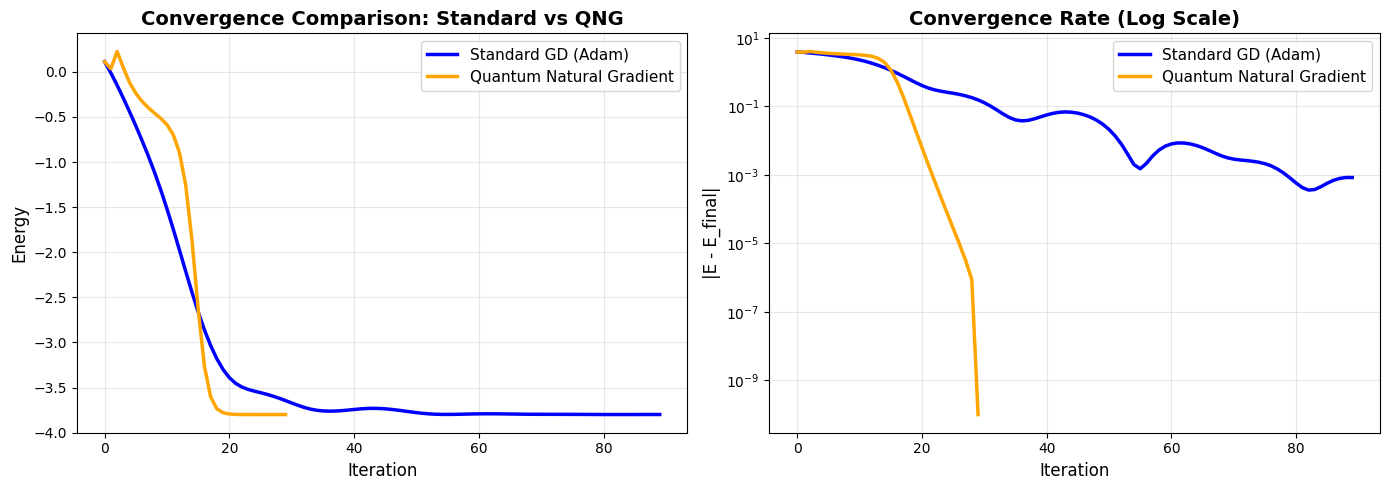

In [60]:
# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Energy evolution
ax1 = axes[0]
ax1.plot(vqe_standard.history_energy, label='Standard GD (Adam)', 
         linewidth=2.5, color='blue')
ax1.plot(vqe_qng.history_energy, label='Quantum Natural Gradient', 
         linewidth=2.5, color='orange')
ax1.set_xlabel('Iteration', fontsize=12)
ax1.set_ylabel('Energy', fontsize=12)
ax1.set_title('Convergence Comparison: Standard vs QNG', 
              fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Convergence rate (log scale)
ax2 = axes[1]
# Compute distance from final energy
baseline = min(E_std, E_qng)
error_std = np.abs(np.array(vqe_standard.history_energy) - baseline)
error_qng = np.abs(np.array(vqe_qng.history_energy) - baseline)

# Avoid log(0)
error_std = np.maximum(error_std, 1e-10)
error_qng = np.maximum(error_qng, 1e-10)

ax2.semilogy(error_std, label='Standard GD (Adam)', linewidth=2.5, color='blue')
ax2.semilogy(error_qng, label='Quantum Natural Gradient', linewidth=2.5, color='orange')
ax2.set_xlabel('Iteration', fontsize=12)
ax2.set_ylabel('|E - E_final|', fontsize=12)
ax2.set_title('Convergence Rate (Log Scale)', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'qng_vs_standard.png', dpi=300, bbox_inches='tight')
print(f" Saved: {RESULTS_DIR / 'qng_vs_standard.png'}")


Enhanced Ising Comparison: Multiple Runs per Optimizer

--- Const. ---
  Run 1/20
Iteration 0/200 (0.0%)
Iteration 10/200 (5.0%)
Iteration 20/200 (10.0%)
Iteration 30/200 (15.0%)
Iteration 40/200 (20.0%)
Iteration 50/200 (25.0%)
Iteration 60/200 (30.0%)
Iteration 70/200 (35.0%)
Iteration 80/200 (40.0%)
Iteration 90/200 (45.0%)
Iteration 100/200 (50.0%)
Iteration 110/200 (55.0%)
Iteration 120/200 (60.0%)
Iteration 130/200 (65.0%)
Iteration 140/200 (70.0%)
Iteration 150/200 (75.0%)
Iteration 160/200 (80.0%)
Iteration 170/200 (85.0%)
Iteration 180/200 (90.0%)
Iteration 190/200 (95.0%)
Iteration 0/200 (0.0%)
Iteration 10/200 (5.0%)
Iteration 20/200 (10.0%)
Iteration 30/200 (15.0%)
Iteration 40/200 (20.0%)
Iteration 50/200 (25.0%)
Iteration 60/200 (30.0%)
Iteration 70/200 (35.0%)
Iteration 80/200 (40.0%)
Iteration 90/200 (45.0%)
Iteration 100/200 (50.0%)
Iteration 110/200 (55.0%)
Iteration 120/200 (60.0%)
Iteration 130/200 (65.0%)
Iteration 140/200 (70.0%)
Iteration 150/200 (75.0%)
Iterati

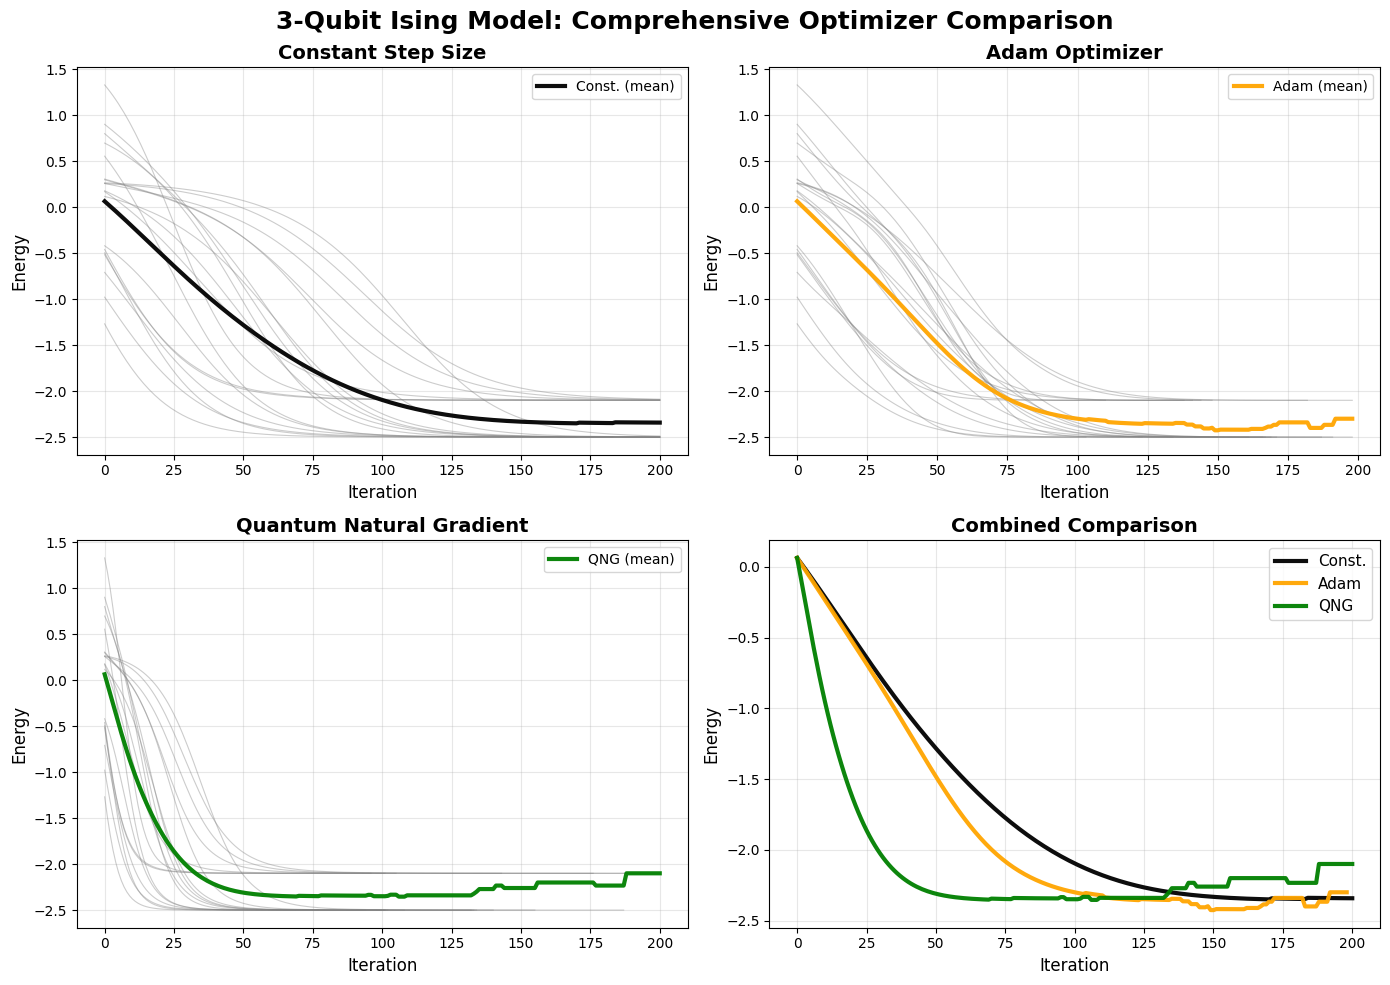


 Saved: results/demo/ising_comprehensive_comparison.png


In [66]:
print("\n" + "=" * 80)
print("Enhanced Ising Comparison: Multiple Runs per Optimizer")
print("=" * 80)

k = 20   # number of random runs per optimizer

# Set seed and generate initial parameters
np.random.seed(42)
initial_thetas = [np.random.uniform(0, 2*np.pi, n_params) for _ in range(k)]

# Define optimizers
optimizers_config = {
    'Const.': {
        'class': VQE_Ising_PSR_const,
        'params': {'max_iter': 200, 'learning_rate': 0.02, 'store_history': True, 
                   'reps': opti_reps, 'J': J, 'h': h}
    },
    'Adam': {
        'class': VQE_Ising_PSR_Adam,
        'params': {'max_iter': 200, 'learning_rate': 0.02, 'store_history': True, 
                   'reps': opti_reps, 'J': J, 'h': h}
    },
    'QNG': {
        'class': VQE_Ising_QNG,
        'params': {'max_iter': 200, 'learning_rate': 0.02, 'decay': 0.02, 
                   'store_history': True, 'reps': opti_reps, 'J': J, 'h': h}
    }
}

all_results = {name: [] for name in optimizers_config}

# Run experiments
for opti_name, config in optimizers_config.items():
    print(f"\n--- {opti_name} ---")
    for idx, theta0 in enumerate(initial_thetas):
        if idx % 5 == 0:
            print(f"  Run {idx+1}/{k}")
        
        vqe = config['class'](**config['params'])
        theta_opt, E_opt = vqe.run(initial_params=theta0.copy())
        
        all_results[opti_name].append({
            "energy": E_opt,
            "history": vqe.history_energy
        })
    
    energies = [r["energy"] for r in all_results[opti_name]]
    print(f"  Mean: {np.mean(energies):.6f} ± {np.std(energies):.6f}")

# Compute mean curves
def compute_mean_curve(histories):
    max_len = max(len(h) for h in histories)
    padded = np.array([
        np.pad(np.array(h), (0, max_len - len(h)), constant_values=np.nan)
        for h in histories
    ])
    return np.nanmean(padded, axis=0)

mean_curves = {name: compute_mean_curve([r["history"] for r in all_results[name]]) 
               for name in optimizers_config}



fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("3-Qubit Ising Model: Comprehensive Optimizer Comparison",
             fontsize=18, fontweight='bold')

colors = {'Const.': 'black', 'Adam': 'orange', 'QNG': 'green'}
titles = {'Const.': "Constant Step Size", 'Adam': "Adam Optimizer", 
          'QNG': "Quantum Natural Gradient"}

# First 3 subplots: individual optimizer details
for ax, name in zip(axes.flat[:3], ['Const.', 'Adam', 'QNG']):
    histories = [r["history"] for r in all_results[name]]
    
    # Gray individual runs
    for hist in histories:
        ax.plot(hist, color='gray', linewidth=0.8, alpha=0.4)
    
    # Colored mean curve
    ax.plot(mean_curves[name], color=colors[name], linewidth=3.0,
            label=f'{name} (mean)', alpha=0.95)
    
    ax.set_title(titles[name], fontsize=14, fontweight='bold')
    ax.set_xlabel('Iteration', fontsize=12)
    ax.set_ylabel('Energy', fontsize=12)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

# Fourth subplot: COMBINED COMPARISON (not colorbar!)
ax_comp = axes[1, 1]

for name in ['Const.', 'Adam', 'QNG']:
    ax_comp.plot(mean_curves[name], color=colors[name], linewidth=3.0,
                 label=name, alpha=0.95)

ax_comp.set_title("Combined Comparison", fontsize=14, fontweight='bold')
ax_comp.set_xlabel('Iteration', fontsize=12)
ax_comp.set_ylabel('Energy', fontsize=12)
ax_comp.legend(fontsize=11)
ax_comp.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'ising_comprehensive_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"\n Saved: {RESULTS_DIR / 'ising_comprehensive_comparison.png'}")

---
## Part 3: Hydrogen Molecule (H2)

Computing the potential energy curve for the hydrogen molecule:

$$E(d) = \langle \psi(d) | H_{\text{el}} | \psi(d) \rangle + E_{\text{nuc}}(d)$$

where $d$ is the bond distance. We use:
- **Basis**: STO-3G (minimal basis)
- **Mapping**: Jordan-Wigner transformation
- **Initial State**: Hartree-Fock

**Experimental**: $d_{\text{eq}} \approx 0.74$ Å, $E_0 \approx -1.174$ Ha


H₂ Ansatz Depth Analysis

reps = 0
Iteration 0/150 (0.0%)
Iteration 10/150 (6.7%)
Iteration 20/150 (13.3%)
Iteration 30/150 (20.0%)
Iteration 40/150 (26.7%)
Iteration 50/150 (33.3%)
Iteration 60/150 (40.0%)
Iteration 70/150 (46.7%)
Iteration 80/150 (53.3%)
Iteration 90/150 (60.0%)
Iteration 100/150 (66.7%)
Iteration 110/150 (73.3%)
Iteration 120/150 (80.0%)
Iteration 130/150 (86.7%)
Iteration 140/150 (93.3%)
  Energy: -1.117271 Ha (4 params)

reps = 1
Iteration 0/150 (0.0%)
Iteration 10/150 (6.7%)
Iteration 20/150 (13.3%)
Iteration 30/150 (20.0%)
Iteration 40/150 (26.7%)
Iteration 50/150 (33.3%)
Iteration 60/150 (40.0%)
Iteration 70/150 (46.7%)
Iteration 80/150 (53.3%)
Iteration 90/150 (60.0%)
Iteration 100/150 (66.7%)
Iteration 110/150 (73.3%)
Iteration 120/150 (80.0%)
Iteration 130/150 (86.7%)
Iteration 140/150 (93.3%)
  Energy: -1.100118 Ha (8 params)

reps = 2
Iteration 0/150 (0.0%)
Iteration 10/150 (6.7%)
Iteration 20/150 (13.3%)
Iteration 30/150 (20.0%)
Iteration 40/150 (26.7%)


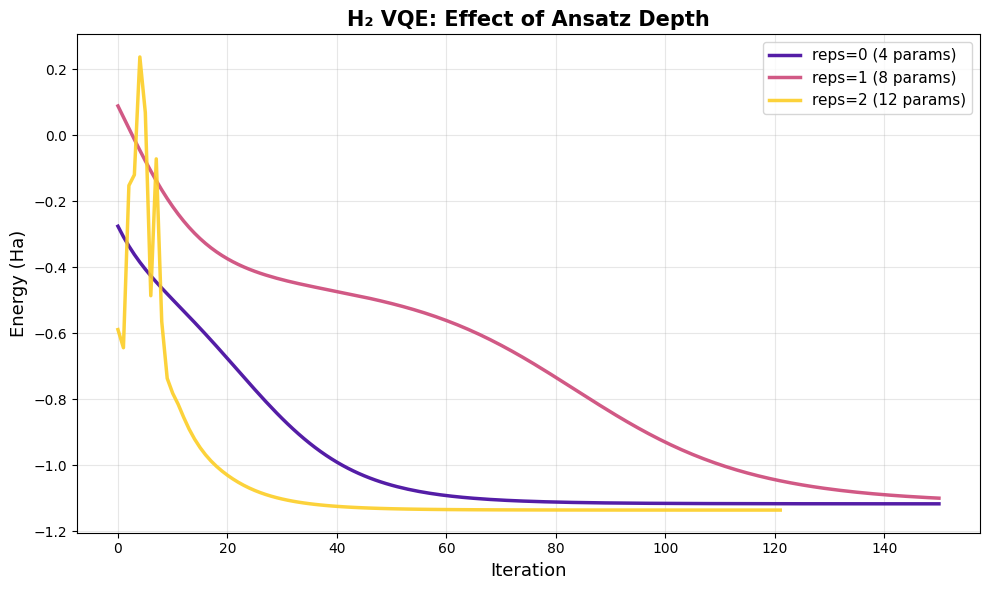


 Saved: results/demo/h2_ansatz_depth.png


In [71]:
# H2 Ansatz Depth Comparison

print("\n" + "=" * 80)
print("H₂ Ansatz Depth Analysis")
print("=" * 80)

distance = 0.70  # Å
reps_list = [0, 1, 2]
num_qubits = 4

histories = {}
final_energies = {}

for reps in reps_list:
    print(f"\nreps = {reps}")
    
    vqe_h2 = VQE_H2_QNG(
        max_iter=150, learning_rate=0.05, decay=0.01,
        store_history=True, reps=reps, distance=distance
    )
    
    n_params = (reps + 1) * num_qubits
    theta_init = np.array([np.pi * i / n_params for i in range(n_params)])
    
    theta_opt, E_opt = vqe_h2.run(initial_params=theta_init)
    
    histories[reps] = vqe_h2.history_energy
    final_energies[reps] = E_opt
    
    print(f"  Energy: {E_opt:.6f} Ha ({n_params} params)")

fig, ax = plt.subplots(figsize=(10, 6))

colors = plt.cm.plasma(np.linspace(0.1, 0.9, len(reps_list)))

for reps, color in zip(reps_list, colors):
    n_params = (reps + 1) * num_qubits
    ax.plot(histories[reps], color=color, linewidth=2.5,
            label=f'reps={reps} ({n_params} params)', alpha=0.9)

ax.set_xlabel('Iteration', fontsize=13)
ax.set_ylabel('Energy (Ha)', fontsize=13)
ax.set_title('H₂ VQE: Effect of Ansatz Depth', fontsize=15, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'h2_ansatz_depth.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"\n Saved: {RESULTS_DIR / 'h2_ansatz_depth.png'}")

In [50]:
# Scan bond distances
distances = np.linspace(0.4, 2.0, 24)
energies_qng = []

for i, d in enumerate(distances):
    print(f"Distance {i+1}/{len(distances)}: {d:.2f} Å")
    
    vqe_qng = VQE_H2_QNG(
        max_iter=100,
        learning_rate=0.05,
        decay=0.02,
        reps=1,
        distance=d,
        store_history=False
    )
    
    n_params = (vqe_qng.reps + 1) * 4  # 4 qubits for H2
    theta_init = np.linspace(0, np.pi, n_params)
    
    _, E_qng = vqe_qng.run(theta_init)
    energies_qng.append(E_qng)
    
    print(f"  QNG: {E_qng:.6f} Ha\n")

Distance 1/24: 0.40 Å
Iteration 0/100 (0.0%)
Iteration 10/100 (10.0%)
Iteration 20/100 (20.0%)
Iteration 30/100 (30.0%)
Iteration 40/100 (40.0%)
Iteration 50/100 (50.0%)
Iteration 60/100 (60.0%)
Iteration 70/100 (70.0%)
Iteration 80/100 (80.0%)
Iteration 90/100 (90.0%)
  QNG: -0.911777 Ha

Distance 2/24: 0.47 Å
Iteration 0/100 (0.0%)
Iteration 10/100 (10.0%)
Iteration 20/100 (20.0%)
Iteration 30/100 (30.0%)
Iteration 40/100 (40.0%)
Iteration 50/100 (50.0%)
Iteration 60/100 (60.0%)
Iteration 70/100 (70.0%)
Iteration 80/100 (80.0%)
Iteration 90/100 (90.0%)
  QNG: -1.019736 Ha

Distance 3/24: 0.54 Å
Iteration 0/100 (0.0%)
Iteration 10/100 (10.0%)
Iteration 20/100 (20.0%)
Iteration 30/100 (30.0%)
Iteration 40/100 (40.0%)
Iteration 50/100 (50.0%)
Iteration 60/100 (60.0%)
Iteration 70/100 (70.0%)
Iteration 80/100 (80.0%)
Iteration 90/100 (90.0%)
  QNG: -1.080221 Ha

Distance 4/24: 0.61 Å
Iteration 0/100 (0.0%)
Iteration 10/100 (10.0%)
Iteration 20/100 (20.0%)
Iteration 30/100 (30.0%)
Iterati

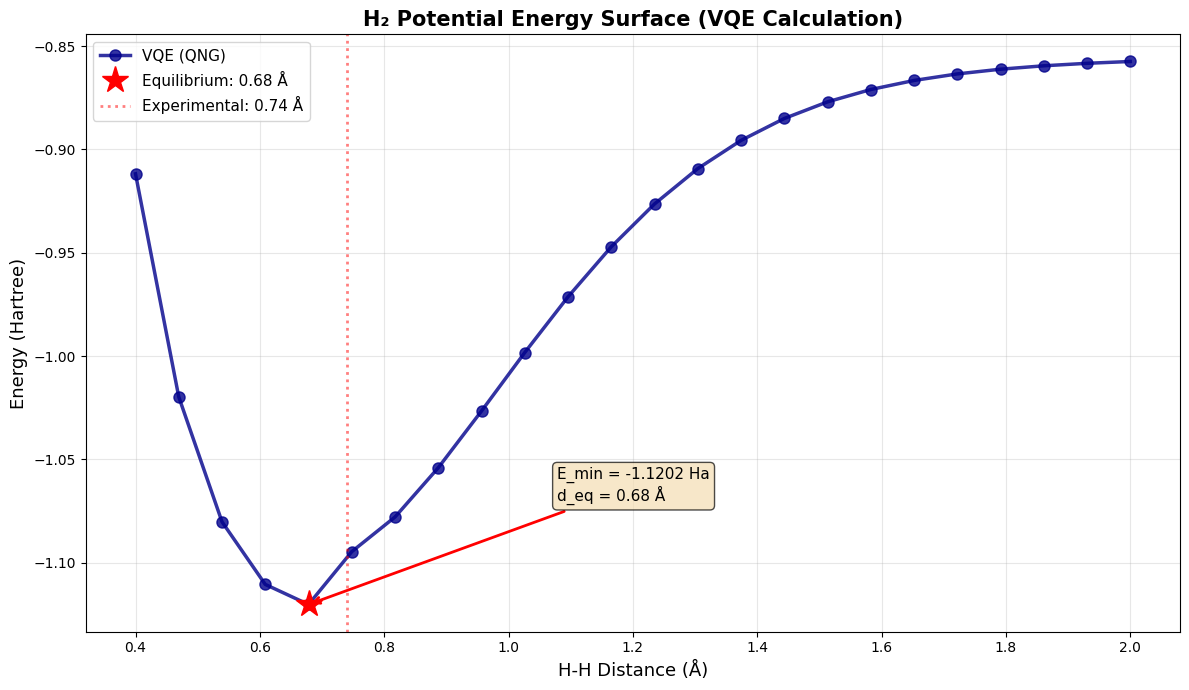


 Saved: results/demo/h2_potential_curve.png

VQE Results:
  Equilibrium bond length: 0.68 Å
  Ground state energy: -1.120228 Ha

Experimental:
  Equilibrium: ~0.74 Å
  Energy: ~-1.174 Ha


In [51]:
# Plot potential energy curves
fig, ax = plt.subplots(1, 1, figsize=(12, 7))

# Plot both methods
ax.plot(distances, energies_qng, 'o-', linewidth=2.5, markersize=8, 
        color='darkblue', label='VQE (QNG)', alpha=0.8)

# Mark equilibrium for QNG
min_idx_qng = np.argmin(energies_qng)
eq_distance_qng = distances[min_idx_qng]
eq_energy_qng = energies_qng[min_idx_qng]
ax.plot(eq_distance_qng, eq_energy_qng, 'r*', markersize=20, 
        label=f'Equilibrium: {eq_distance_qng:.2f} Å')

# Mark experimental value
ax.axvline(x=0.74, color='red', linestyle=':', linewidth=2, alpha=0.5,
           label='Experimental: 0.74 Å')

ax.set_xlabel('H-H Distance (Å)', fontsize=13)
ax.set_ylabel('Energy (Hartree)', fontsize=13)
ax.set_title('H₂ Potential Energy Surface (VQE Calculation)', 
             fontsize=15, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11, loc='best')

# Add annotation
ax.annotate(f'E_min = {eq_energy_qng:.4f} Ha\nd_eq = {eq_distance_qng:.2f} Å',
            xy=(eq_distance_qng, eq_energy_qng), 
            xytext=(eq_distance_qng + 0.4, eq_energy_qng + 0.05),
            arrowprops=dict(arrowstyle='->', color='red', lw=2),
            fontsize=11, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'h2_potential_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n Saved: {RESULTS_DIR / 'h2_potential_curve.png'}")
print(f"\nVQE Results:")
print(f"  Equilibrium bond length: {eq_distance_qng:.2f} Å")
print(f"  Ground state energy: {eq_energy_qng:.6f} Ha")
print(f"\nExperimental:")
print(f"  Equilibrium: ~0.74 Å")
print(f"  Energy: ~-1.174 Ha")

### Analysis of H2 Results

The VQE calculation captures the key features of the H₂ molecule:

1. **Qualitative shape**: The characteristic potential well is reproduced
2. **Dissociation limit**: Energy approaches correct asymptotic behavior
3. **Limitations**: 
   - Minimal basis (STO-3G) limits accuracy
   - Hardware-efficient ansatz may not capture all correlation
   - For chemical accuracy, might need larger basis + more sophisticated ansatz

---
## Summary and Key Takeaways

### Framework Features

**Modular Design**: Mix and match components freely

**Three Quantum Systems**: Single qubit, Ising model, H2 molecule

**Multiple Gradient Methods**: Finite difference, parameter shift, SPSA

**Advanced Optimizers**: Gradient descent, Adam, quantum natural gradient

**Flexible Ansätze**: Trivial, RealAmplitudes, EfficientSU2